In [14]:
# Install Kaggle API
!pip install kaggle

# Move the uploaded kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [15]:
# Download dataset from Kaggle
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip the dataset
!unzip -o lgg-mri-segmentation.zip -d lgg-mri-segmentation


Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1

In [16]:
!pip install segmentation-models-pytorch torch torchvision albumentations numpy


In [17]:
import os
import glob
from PIL import Image
import numpy as np

# Define dataset path
dataset_path = "lgg-mri-segmentation/kaggle_3m"

# Get all MRI and mask files
all_tif_files = glob.glob(f"{dataset_path}/**/*.tif", recursive=True)

# Separate MRI scans and masks (assuming masks contain "_mask" in filename)
mri_files = sorted([f for f in all_tif_files if "_mask" not in f])
mask_files = sorted([f for f in all_tif_files if "_mask" in f])

# Print sample file names
print("✅ First MRI Image:", mri_files[0])
print("✅ First Mask Image:", mask_files[0])


✅ First MRI Image: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
✅ First Mask Image: lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif


In [18]:
import torch
from torchvision import transforms

# Define preprocessing function
def preprocess_image(image_path, mask=False):
    """Load, resize, normalize, and convert MRI scans & masks to tensors."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize((128, 128))  # Resize to match model input

    image_array = np.array(image) / 255.0  # Normalize pixel values to 0-1

    if mask:  # Masks are binary (0 or 1)
        image_array = (image_array > 0.5).astype(np.float32)  # Convert to binary mask

    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
    return image_tensor


In [19]:
from torch.utils.data import Dataset, DataLoader

class BrainMRIDataset(Dataset):
    """Custom PyTorch Dataset for MRI Segmentation"""
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        mri_image = preprocess_image(self.image_paths[idx])  # Load MRI scan
        mask_image = preprocess_image(self.mask_paths[idx], mask=True)  # Load segmentation mask

        # ✅ Ensure shape is (1, H, W) — no extra dimension
        mri_image = mri_image.unsqueeze(0)  # (1, 128, 128)
        mask_image = mask_image.unsqueeze(0)  # (1, 128, 128)

        return mri_image, mask_image

# ✅ Create dataset
dataset = BrainMRIDataset(mri_files, mask_files)

# ✅ Create DataLoader (Batch, 1, 128, 128)
batch_size = 32  # Increase batch size for speed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


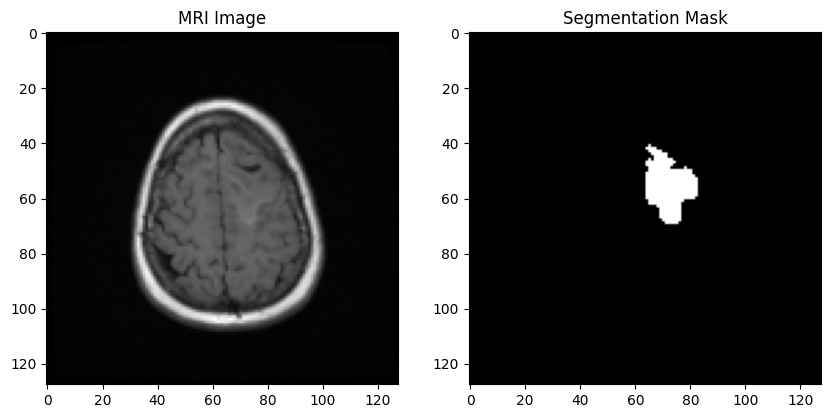

In [20]:
import matplotlib.pyplot as plt

# Get a batch of MRI scans and masks
mri_batch, mask_batch = next(iter(dataloader))

# Convert to NumPy for visualization
mri_sample = mri_batch[0].squeeze().numpy()
mask_sample = mask_batch[0].squeeze().numpy()

# Display MRI and Mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(mri_sample, cmap="gray")

plt.subplot(1,2,2)
plt.title("Segmentation Mask")
plt.imshow(mask_sample, cmap="gray")

plt.show()


In [21]:
import segmentation_models_pytorch as smp
import torch

# Define DeepLabV3+ model
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",   # Choose ResNet34 as backbone
    encoder_weights="imagenet",  # Use pre-trained ImageNet weights
    in_channels=1,  # Grayscale MRI
    classes=1,  # Binary segmentation (tumor vs. background)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model summary
print(model)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [22]:
import time
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda")

# ✅ Define loss function (Binary Cross-Entropy for segmentation)
criterion = nn.BCEWithLogitsLoss()

# ✅ Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        running_loss = 0.0
        batch_count = len(train_loader)

        print(f"\n🚀 Epoch {epoch+1}/{num_epochs} -------------------")

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            # ✅ Ensure correct shape (Batch, 1, 128, 128)
            if images.dim() == 5:  # If extra dimension exists
                images = images.squeeze(1)
                masks = masks.squeeze(1)

            # ✅ Use AMP for faster training
            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, masks)

            # ✅ Backward pass with mixed precision
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"  🔄 Batch {batch_idx+1}/{batch_count} - Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time
        print(f"✅ Epoch {epoch+1} Finished - Loss: {running_loss:.4f}, Time: {epoch_time:.2f} sec")

# ✅ Train DeepLabV3+
train_model(model, dataloader, num_epochs=5)



🚀 Epoch 1/5 -------------------
  🔄 Batch 10/123 - Loss: 0.6424
  🔄 Batch 20/123 - Loss: 0.5431
  🔄 Batch 30/123 - Loss: 0.4410
  🔄 Batch 40/123 - Loss: 0.3553
  🔄 Batch 50/123 - Loss: 0.2891
  🔄 Batch 60/123 - Loss: 0.2402
  🔄 Batch 70/123 - Loss: 0.2122
  🔄 Batch 80/123 - Loss: 0.1946
  🔄 Batch 90/123 - Loss: 0.1674
  🔄 Batch 100/123 - Loss: 0.1659
  🔄 Batch 110/123 - Loss: 0.1483
  🔄 Batch 120/123 - Loss: 0.1632
✅ Epoch 1 Finished - Loss: 38.7221, Time: 18.25 sec

🚀 Epoch 2/5 -------------------
  🔄 Batch 10/123 - Loss: 0.1348
  🔄 Batch 20/123 - Loss: 0.1429
  🔄 Batch 30/123 - Loss: 0.1258
  🔄 Batch 40/123 - Loss: 0.1146
  🔄 Batch 50/123 - Loss: 0.1094
  🔄 Batch 60/123 - Loss: 0.1031
  🔄 Batch 70/123 - Loss: 0.1149
  🔄 Batch 80/123 - Loss: 0.1066
  🔄 Batch 90/123 - Loss: 0.1009
  🔄 Batch 100/123 - Loss: 0.0942
  🔄 Batch 110/123 - Loss: 0.0820
  🔄 Batch 120/123 - Loss: 0.0785
✅ Epoch 2 Finished - Loss: 13.5939, Time: 18.50 sec

🚀 Epoch 3/5 -------------------
  🔄 Batch 10/123 - Loss

In [23]:
torch.save(model.state_dict(), "deeplabv3plus_mri_segmentation.pth")
print("✅ Model saved successfully!")


✅ Model saved successfully!


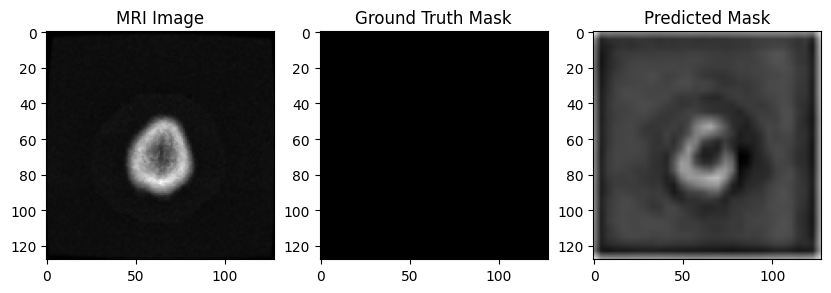

In [24]:
import matplotlib.pyplot as plt

# Load a batch of test images
test_images, test_masks = next(iter(dataloader))

# Select one test image
test_image = test_images[0].unsqueeze(0).squeeze(1).to(device)  # Remove extra channel dimension

# Get model prediction
model.eval()
with torch.no_grad():
    predicted_mask = model(test_image)

# Convert tensors to numpy for visualization
test_image = test_image.cpu().squeeze().numpy()
test_mask = test_masks[0].cpu().squeeze().numpy()
predicted_mask = predicted_mask.cpu().squeeze().numpy()

# Display MRI, Ground Truth, and Prediction
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("MRI Image")
plt.imshow(test_image, cmap="gray")

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(test_mask, cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")

plt.show()


In [26]:
from sklearn.metrics import accuracy_score, jaccard_score

def evaluate_model(model, dataloader):
    model.eval()
    total_accuracy, total_iou = 0.0, 0.0
    num_samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            # ✅ Ensure images are 4D (Batch, 1, 128, 128)
            if images.dim() == 5:
                images = images.squeeze(1)  # Remove extra dimension
                masks = masks.squeeze(1)  # Ensure masks are correctly shaped

            # Get model predictions
            predictions = model(images)
            predictions = (predictions > 0.5).float()  # Convert logits to binary mask

            # Flatten for accuracy computation
            true_mask = masks.cpu().numpy().flatten()
            pred_mask = predictions.cpu().numpy().flatten()

            # Compute accuracy and IoU
            batch_accuracy = accuracy_score(true_mask, pred_mask)
            batch_iou = jaccard_score(true_mask, pred_mask, average='binary')

            total_accuracy += batch_accuracy
            total_iou += batch_iou
            num_samples += 1

    avg_accuracy = total_accuracy / num_samples
    avg_iou = total_iou / num_samples

    return avg_accuracy, avg_iou

# ✅ Re-run model evaluation
accuracy, iou = evaluate_model(model, dataloader)
print(f"✅ DeepLabV3+ Model Accuracy: {accuracy:.4f}")
print(f"✅ DeepLabV3+ Model IoU Score: {iou:.4f}")


✅ DeepLabV3+ Model Accuracy: 0.9914
✅ DeepLabV3+ Model IoU Score: 0.1871
